Markowitz efficient frontier will help us determine how to distribute the capital we have to the different the different companies we want to invest in our portfolio. The Markowitz portfolio optimization problem can be formulated as a mathematical optimization problem, where the objective is to maximize the portfolio's expected return while minimizing its risk. The solution to this problem provides a set of efficient portfolios, known as the efficient frontier, which represents the optimal tradeoff between risk and return. But note that it has its limitation like we use historical data to calculate expected returns and variance

In [21]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
start = dt.datetime(2021, 1,1 )
end = dt.datetime(2021, 1, 22)

Here are the stocks we used in our data. We have done our research and discovered that the following companies have potential. These are Google, Ceva , Tesla, Zoom

In [6]:
ceva = yf.download('CEVA', start= start, end = end)
google = yf.download('GOOGL', start=start,  end = end)
tesla = yf.download('TSLA', start= start, end = end)
zom = yf.download('ZOM', start = start, end= end)

#now we want to concatenate the prices of the 4 stocks
stocks = pd.concat([ceva['Close'], google.Close, tesla.Close, zom.Close], axis = 1)
stocks.columns = ['CEVA', 'GOOGLE', "TESLA", 'ZOMEDICA']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
stocks


,CEVA,GOOGLE,TESLA,ZOMEDICA
Date,,,,
2021-01-04,44.720001,86.306503,243.256668,0.350
2021-01-05,46.430000,87.002502,245.036667,0.439
2021-01-06,48.160000,86.143997,251.993332,0.410
2021-01-07,50.700001,88.717003,272.013336,0.400
2021-01-08,50.910000,89.891502,293.339996,0.484
2021-01-11,54.139999,87.814499,270.396667,0.930
2021-01-12,55.540001,86.871498,283.146667,1.300
2021-01-13,57.119999,87.362503,284.803345,0.976
2021-01-14,55.669998,86.545998,281.666656,1.010


In [10]:
stock_ret = np.log(stocks) - np.log(stocks.shift(1))
stock_ret = stock_ret.dropna()
stock_ret

,CEVA,GOOGLE,TESLA,ZOMEDICA
Date,,,,
2021-01-05,0.037525,0.008032,0.007291,0.226566
2021-01-06,0.036583,-0.009917,0.027995,-0.068342
2021-01-07,0.051397,0.029431,0.076448,-0.024693
2021-01-08,0.004133,0.013152,0.075481,0.190620
2021-01-11,0.061514,-0.023377,-0.081442,0.653100
2021-01-12,0.025530,-0.010797,0.046075,0.334935
2021-01-13,0.028051,0.005636,0.005834,-0.286657
2021-01-14,-0.025713,-0.009390,-0.011075,0.034243
2021-01-15,-0.031754,-0.001908,-0.022548,-0.035268


Now we want to calcualte the Sharpe Ratio. The Sharpe ration is the return of the portofolio if we adjust for risk

$$ SR(w) = (R(w) - R_f)/ \sigma(w) $$

$$ w = [ w_1,  w_2,  w_3,  w_4] $$

$$ \sum_{k=1}^{4}w_k = 1 $$

Since we will look for max $ SR(w) $ and $ R_f $ is common for all $ w's $ the we shall compute:
$$ R(w) = w^Tlog(r) $$

$$ \sigma(w) = \sqrt{w^T \sum w} $$

$$ SR(w) 

In [27]:
noofPortfolios = 100000
weight = np.zeros((noofPortfolios, 4))
expected_return = np.zeros(noofPortfolios)
expected_volatility = np.zeros(noofPortfolios)
SharpeRatio = np.zeros(noofPortfolios)

meanLogret = stock_ret.mean()
sigma = stock_ret.cov()

for i in range(noofPortfolios):
    #genarate random weight vector
    w = np.array(np.random.random(4))
    #now we want to make sure that they add up to zeros
    w = w/np.sum(w)
    weight[i, :] = w
    #expected log return
    expected_return[i] = np.sum(meanLogret * w)
    #expected volatility 
    expected_volatility[i] = np.sqrt(np.dot(w.T, np.dot(sigma, w)))
    # Sharpe Ratio
    SharpeRatio[i] = expected_return[i]/expected_volatility[i]


now we want to find the one with the maximum Sharpe Ratio

In [28]:
maxIndex = SharpeRatio.argmax()
maxSR_weights = weight[maxIndex, :]
maxSR_weights

array([0.23592392, 0.45350808, 0.23846291, 0.07210509])

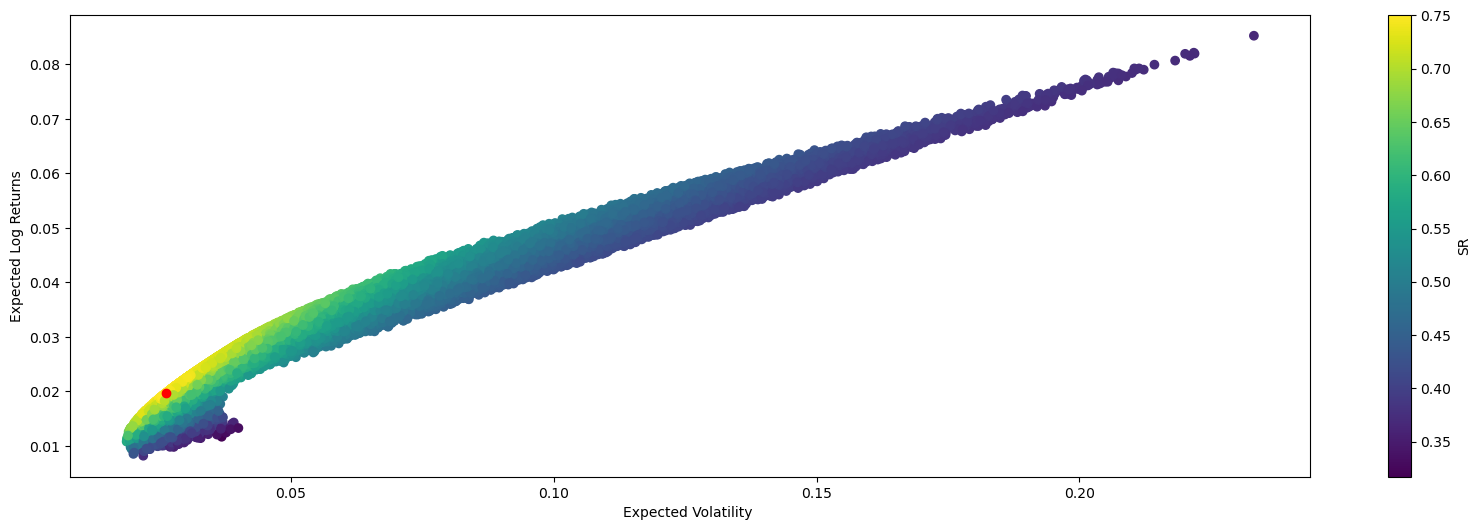

In [31]:
plt.figure(figsize= (20, 6))
plt.scatter(expected_volatility, expected_return, c= SharpeRatio)
plt.xlabel('Expected Volatility ')
plt.ylabel('Expected Log Returns')
plt.colorbar(label = 'SR')
#This is to show the efficient frontier point we have calculated before
plt.scatter(expected_volatility[maxIndex], expected_return[maxIndex], c= 'red')
plt.show()

Now we want to use the scipy function to get the optimization point

In [37]:
from scipy.optimize import minimize

def negativeSR(w):
    w = np.array(w)
    R = np.sum(meanLogret*w)
    V= np.sqrt(np.dot(w.T, np.dot(sigma ,w)))
    SR = R/V
    return -1*SR

def CheckSumToOne(w):
    return np.sum(w)- 1
    
#w_0 is an initial estiamtion of where to start
w0 = [0.25, 0.25, 0.25, 0.25]
#bounds are that each weight is between 0 and 1
bounds  = ((0,1), (0,1), (0,1), (0,1))
#constraints 
constraints = ({'type':'eq', 'fun': CheckSumToOne})

w_opt =  minimize(negativeSR, w0, method = 'SLSQP', bounds= bounds, constraints= constraints)
w_opt

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.7506237585454375
       x: [ 2.386e-01  4.543e-01  2.341e-01  7.296e-02]
     nit: 9
     jac: [-3.436e-04 -1.366e-04  2.795e-04  1.077e-03]
    nfev: 46
    njev: 9

In [38]:
w_opt.x

array([0.23857859, 0.4543222 , 0.23413739, 0.07296182])

Now we want to find the maximize point like we did in the graph

In [39]:
returns = np.linspace(0, 0.09, 50)
volatility_opt = []
def minimizeVolatility(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T, np.dot(sigma, w)))
    return V

def getReturn(w):
    w = np.array(w)
    R = np.sum(meanLogret*w)
    return R

for R in returns:
    #find best volatility
    constraints = ({'type':'eq', 'fun': CheckSumToOne},
                   {'type':'eq', 'fun': lambda w: getReturn(w)- R})
    opt = minimize(minimizeVolatility, w0, method= 'SLSQP', bounds= bounds, constraints=constraints)
    volatility_opt.append(opt['fun'])

In [40]:
volatility_opt

[0.021586479866340547,
 0.021586479866333417,
 0.021586479866341577,
 0.021586479866337528,
 0.021514769748811488,
 0.019413231195842418,
 0.01868361246718552,
 0.0192880197419843,
 0.020634720229437842,
 0.022416466454450584,
 0.024538748834157978,
 0.02692103639601859,
 0.02950057221564227,
 0.03223522094228535,
 0.03507431043198395,
 0.03800816337736482,
 0.041040566322084686,
 0.04445504502641518,
 0.0482469064680084,
 0.05233384466796514,
 0.0566524171938622,
 0.06115352338937638,
 0.06580175353370328,
 0.0708000733339713,
 0.07622447866600585,
 0.08199044482140594,
 0.08803088128514223,
 0.0942930549492714,
 0.10073562185719974,
 0.1073261010615299,
 0.11403885089270868,
 0.12085349895716092,
 0.12775373985682817,
 0.13472642295250528,
 0.14176085907424388,
 0.14884829351371645,
 0.1559815014202043,
 0.16315447996761448,
 0.17036220542614833,
 0.1776004471145498,
 0.184865620724067,
 0.19215467217574228,
 0.1994649825401738,
 0.20679429783512984,
 0.2141406666448123,
 0.221502392

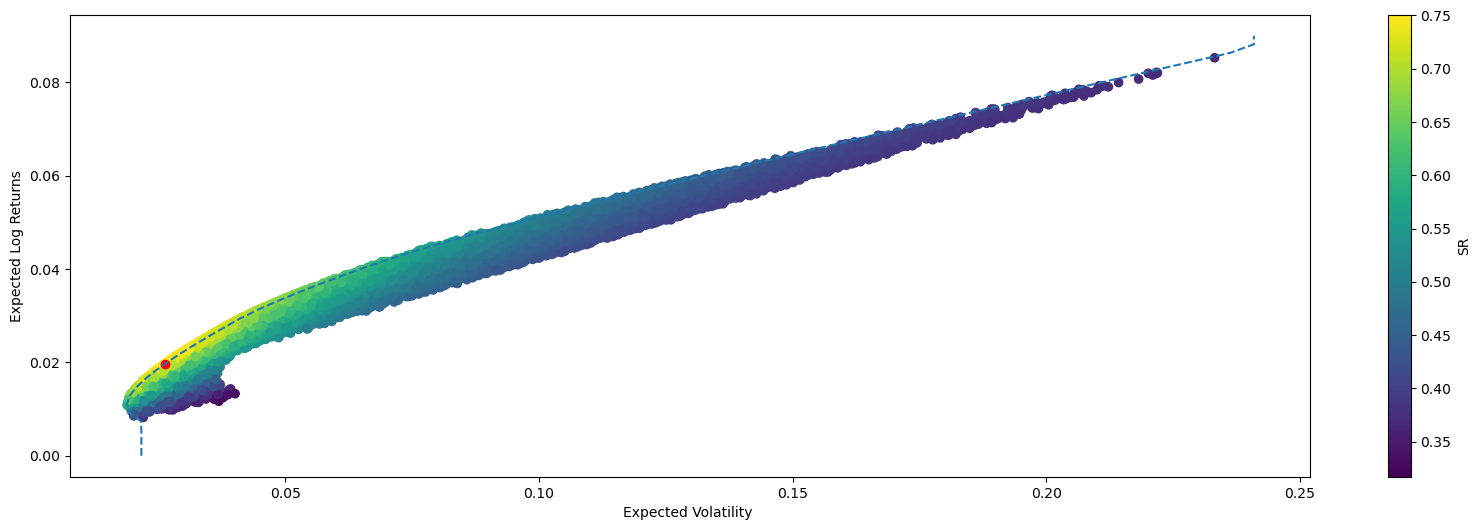

In [41]:
plt.figure(figsize= (20, 6))
plt.scatter(expected_volatility, expected_return, c= SharpeRatio)
plt.xlabel('Expected Volatility ')
plt.ylabel('Expected Log Returns')
plt.colorbar(label = 'SR')
#This is to show the efficient frontier point we have calculated before
plt.scatter(expected_volatility[maxIndex], expected_return[maxIndex], c= 'red')
plt.plot(volatility_opt, returns, '--')
plt.show()

the dotted line represents the optimal frontier that shows the level that minimize the volatility for a given level return